This notebook takes a model trained on CIFAR-10 and gets ROC curve for OOD detection assuming SVHN to be the OOD dataset. 

In [1]:
import os
import sys
cwd = os.getcwd()
module_path = "/".join(cwd.split('/')[0:-1])
if module_path not in sys.path:
    sys.path.append(module_path)
import torch
import random
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn

In [2]:
# Import dataloaders
import Data.cifar10 as cifar10
import Data.svhn as svhn

In [3]:
# Import network architectures
from Net.resnet import resnet50, resnet110
from Net.wide_resnet import wide_resnet_cifar
from Net.densenet import densenet121

In [4]:
# Import metrics to compute
from Metrics.ood_test_utils import get_roc_auc

In [5]:
# Import plot related libraries
import seaborn as sb
import matplotlib.pyplot as plt

In [6]:
# Dataset params
dataset_num_classes = {
    'cifar10': 10,
    'svhn': 10
}

dataset_loader = {
    'cifar10': cifar10,
    'svhn': svhn
}

In [7]:
# Mapping model name to model function
models = {
    'resnet50': resnet50,
    'resnet110': resnet110,
    'wide_resnet': wide_resnet_cifar,
    'densenet121': densenet121,
}

In [8]:
# Checking if GPU is available
cuda = False
if (torch.cuda.is_available()):
    cuda = True

# Setting additional parameters
torch.manual_seed(1)
device = torch.device("cuda" if cuda else "cpu")

In [9]:
class args:
    data_aug = True
    gpu = device == "cuda"
    train_batch_size = 128
    test_batch_size = 128

In [10]:
dataset = 'cifar10'
ood_dataset = 'svhn'

num_classes = dataset_num_classes[dataset]
train_loader, val_loader = dataset_loader[dataset].get_train_valid_loader(
    batch_size=args.train_batch_size,
    augment=args.data_aug,
    random_seed=1,
    pin_memory=args.gpu
)

test_loader = dataset_loader[dataset].get_test_loader(
    batch_size=args.test_batch_size,
    pin_memory=args.gpu
)


ood_train_loader, ood_val_loader = dataset_loader[ood_dataset].get_train_valid_loader(
    batch_size=args.train_batch_size,
    augment=args.data_aug,
    random_seed=1,
    pin_memory=args.gpu
)

ood_test_loader = dataset_loader[ood_dataset].get_test_loader(
    batch_size=args.test_batch_size,
    pin_memory=args.gpu
)

Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [11]:
# Taking input for the model
print ('Enter the model: ')
model_name = input()
print ('Enter saved model name: ')
saved_model_name = input()

model = models[model_name]

Enter the model: 
resnet50
Enter saved model name: 
resnet50_cross_entropy_350.model


In [12]:
net = model(num_classes=num_classes, temp=1.0)
net.cuda()
net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
cudnn.benchmark = True
net.load_state_dict(torch.load('./' + str(saved_model_name)))

(fpr_entropy, tpr_entropy, thresholds_entropy), (fpr_confidence, tpr_confidence, thresholds_confidence), auc_entropy, auc_confidence = get_roc_auc(net, test_loader, ood_test_loader, device)

AUROC entropy: 0.9433005646896128


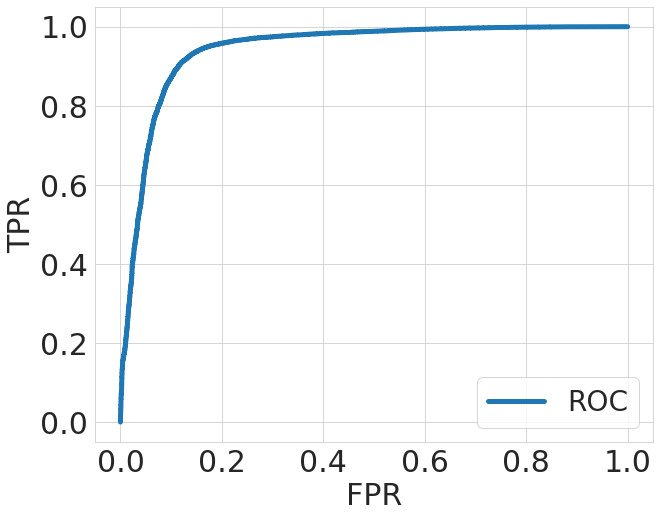

In [15]:
clrs = ['#1f77b4','#ff7f0e', '#2ca02c','#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22','#17becf']

plt.figure()
plt.rcParams["figure.figsize"] = (10, 8)
sb.set_style('whitegrid')
plt.plot(fpr_entropy, tpr_entropy, color=clrs[0], linewidth=5, label='ROC')

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel('FPR', fontsize=30)
plt.ylabel('TPR', fontsize=30)
plt.legend(fontsize=28)
        
print ('AUROC entropy: ' + str(auc_entropy))